In [9]:
# imports y carga del CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import os
from sklearn.preprocessing import OneHotEncoder


csv_path = "data/AIMLDataset.csv"
assert os.path.exists(csv_path), f"Archivo no encontrado: {csv_path}"

df = pd.read_csv(csv_path)

Contexto de lo que se hará: vamos a contar cuántos registros son fraude (1) y cuántos no (0).

Conteo de fraudes vs no fraudes:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


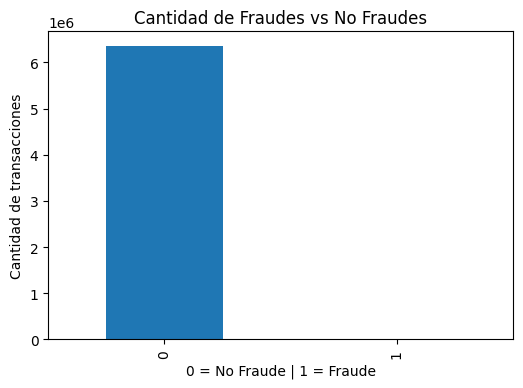

In [6]:
# Conteo de fraudes y no fraudes
fraudes = df["isFraud"].value_counts()

print("Conteo de fraudes vs no fraudes:")
print(fraudes)

# Gráfico de barras
plt.figure(figsize=(6,4))
fraudes.plot(kind="bar")
plt.title("Cantidad de Fraudes vs No Fraudes")
plt.xlabel("0 = No Fraude | 1 = Fraude")
plt.ylabel("Cantidad de transacciones")
plt.show()

colocar el cotexto de lo que se hará: 
-cuenta cuántas veces aparece cada tipo (CASH_OUT, TRANSFER, etc.)
-Se muestra con un gráfico circular
-Esto nos dice qué transacciones son más comunes.
-Importante porque algunos tipos de transacción son más propensos a fraude (ejemplo: TRANSFER).

Distribución de tipos de transacción:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


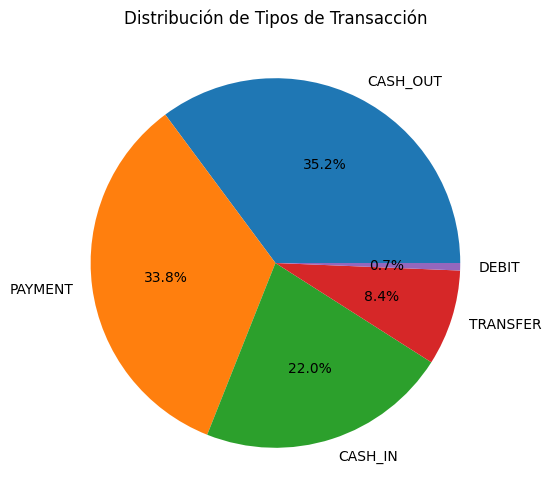

In [7]:
# Conteo de cada tipo de transacción
tipos = df["type"].value_counts()

print("Distribución de tipos de transacción:")
print(tipos)

# Gráfico circular
plt.figure(figsize=(6,6))
tipos.plot(kind="pie", autopct="%1.1f%%")
plt.title("Distribución de Tipos de Transacción")
plt.ylabel("")
plt.show()


colocar el cotexto de lo que se hará: - Agrupa por isFraud y describe la columna amount

Donde vamos a comparar las montons de transacciones de faude o no fraude
.describe() calcula estadísticas (media, mediana, percentiles, máximos).

In [8]:
# Montos en transacciones fraudulentas vs no fraudulentas
df.groupby("isFraud")["amount"].describe()


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


Para las Visualizaciones
- Histograma de montos
Se grafica histograma en la escala logarítmica para comprimir la tabla un poco por la realcion de montos bajos con los montos bajos. Lo que nos permite ver mejor la distibución en la grafica 

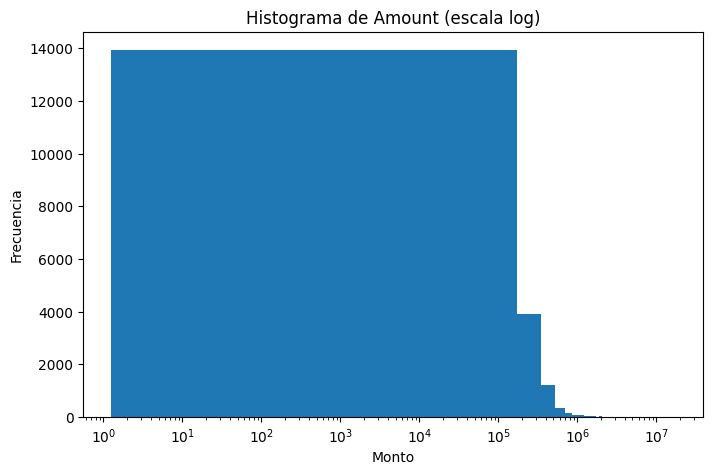

In [9]:
plt.figure(figsize=(8,5))
plt.hist(df['amount'].sample(n=20000, random_state=42), bins=100)
plt.xscale('log')  # Escala logarítmica para ver mejor
plt.title("Histograma de Amount (escala log)")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()


- Boxplots por tipo de transacción. 
Acá dibujamos los Boxplots para cada tipo de transacción, tambien con esacala logaritmica.  cuáles tienen montos generalmente mayores o más dispersos TRANSFER suele llevar montos grandes. 

Con el Boxplots nos podemos ayudar a ver robustamente medianas y dispersión sin que los outliers dominen.

<Figure size 1000x600 with 0 Axes>

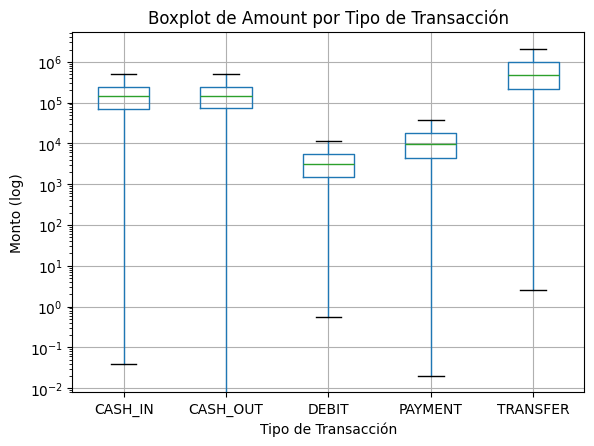

In [10]:
plt.figure(figsize=(10,6))
df.boxplot(column="amount", by="type", showfliers=False)
plt.yscale("log")
plt.title("Boxplot de Amount por Tipo de Transacción")
plt.suptitle("")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Monto (log)")
plt.show()


- Serie temporal de fraudes por step. Donde el Step significa que cada unidad equivale a 1 hora en el dataset. 
Muestra si los fraudes son constantes o aparecen en “picos”/ ventana de tiempo en que se eejcuta un ataque masivo

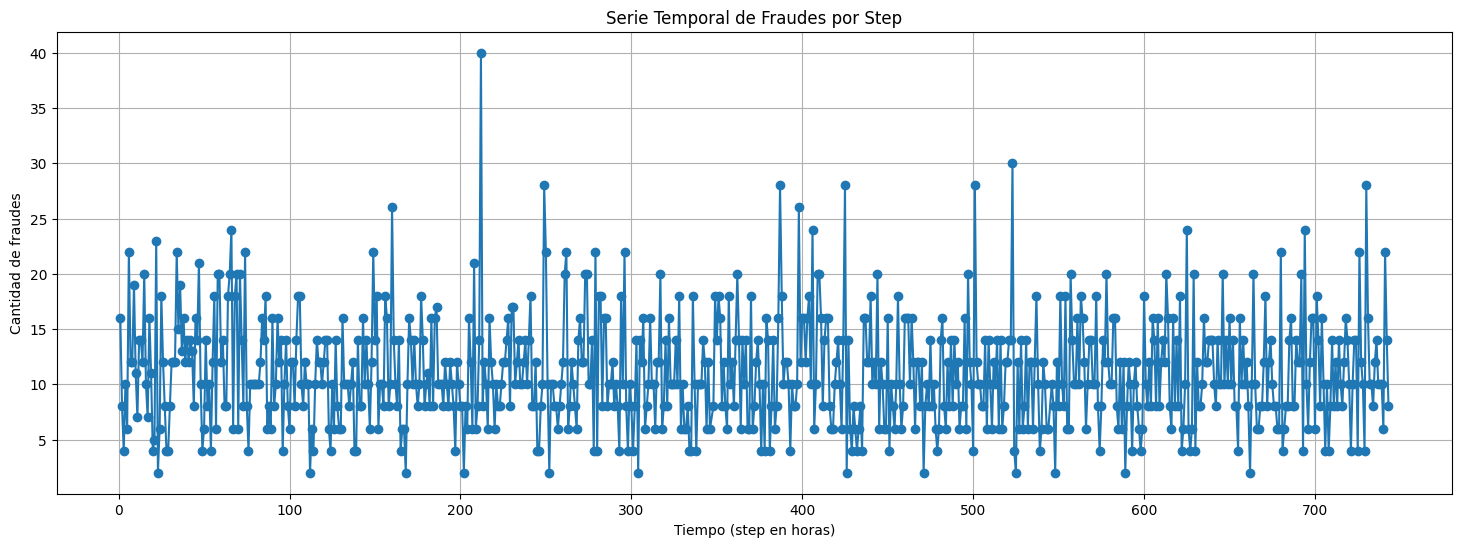

In [ ]:
fraudes_por_step = df[df["isFraud"] == 1].groupby("step").size()

plt.figure(figsize=(18,6))
plt.plot(fraudes_por_step.index, fraudes_por_step.values, marker="o")
plt.title("Serie Temporal de Fraudes por Step")
plt.xlabel("Tiempo (step en horas)")
plt.ylabel("Cantidad de fraudes")
plt.grid(True)
plt.show()


3. Correlaciones y anomalías
Al mirar los datos concretos de fraudes podemos entender cómo se comportan los balances cuando ocurre fraude pequeño ejemplo; montos que vacían cuentas, balances destino en ceros
- Se Comparan los balances iniciales y finales en fraudes 


In [15]:
# Revisamos si hay diferencias grandes en balances
df_fraudes = df[df["isFraud"] == 1][["oldbalanceOrg", "newbalanceOrig", "amount"]]
df_fraudes.head()


,oldbalanceOrg,newbalanceOrig,amount
2,181.0,0.0,181.0
3,181.0,0.0,181.0
251,2806.0,0.0,2806.0
252,2806.0,0.0,2806.0
680,20128.0,0.0,20128.0


¿Se cumplen relaciones lógicas?
- explicar que pasa en el siguiente codigo: 
Se preparan los datos para agrupar transacciones y luego analizar si ciertos clusters tienen más fraudes.

In [17]:
df["check_balance"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]

# Vemos si hay inconsistencias en fraudes
df[df["isFraud"] == 1]["check_balance"].describe()


count    8.213000e+03
mean    -1.069233e+04
std      2.651461e+05
min     -1.000000e+07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.725290e-09
Name: check_balance, dtype: float64

Preprocesamiento para clustering
-Selección de variables: Estas features son las que usaremos para agrupar transacciones (K-Means).

Observación práctica: asegúrate de tratar nulos antes de codificar; si hay nulos en balances/trazas hay que imputarlos o filtrarlos.

Hecho con chatttttt

In [18]:
# Variables candidatas
variables = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]].copy()

# Codificación de la variable categórica "type"
variables = pd.concat([variables, pd.get_dummies(df["type"], drop_first=True)], axis=1)

variables.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,False,False,True,False
1,1864.28,21249.0,19384.72,0.0,0.0,False,False,True,False
2,181.00,181.0,0.00,0.0,0.0,False,False,False,True
3,181.00,181.0,0.00,21182.0,0.0,True,False,False,False
4,11668.14,41554.0,29885.86,0.0,0.0,False,False,True,False


-Escalado de valores numéricos
Explciar:

StandardScaler() → crea el “normalizador”.

fit_transform(variables) →

fit: calcula media y desviación de cada columna.


variables_scaled → es un array de NumPy con los valores ya estandarizados.

.shape → te dice cuántas filas (transacciones) y cuántas columnas (features) tienes después del escalado.

In [21]:

scaler = StandardScaler()

# 2. Aplicamos el escalado a las variables seleccionadas
variables_scaled = scaler.fit_transform(variables)

# 3. Revisamos la forma del nuevo dataset
print("Tamaño del dataset escalado:", variables_scaled.shape)



Tamaño del dataset escalado: (6362620, 9)


In [11]:
##Se seleccionan las columnas que se van a utilizar para agrupar los datos para aplicar el algoritmo de K-means

##Se toman unicamente las variables que cuentan con datos numericos y la variable tipo que es categorica para identificar el tipo de movimiento realizado
df= df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "type"]]
##Debido a que type es una columna categorica, se procede a convertirla en numerica para que pueda ser utilizada en el algoritmo de K-means, para esto se implementa la tecnica de one-hot-encoding
encoder = OneHotEncoder(sparse_output=False, drop="first")  # drop="first" evita multicolinealidad
type_encoded = encoder.fit_transform(df[["type"]])
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(["type"]))
# Concatenar al dataset original y eliminar la columna 'type'
df = pd.concat([df.drop("type", axis=1).reset_index(drop=True), type_encoded_df.reset_index(drop=True)], axis=1)

print(df.head())

     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0   9839.64       170136.0       160296.36             0.0             0.0   
1   1864.28        21249.0        19384.72             0.0             0.0   
2    181.00          181.0            0.00             0.0             0.0   
3    181.00          181.0            0.00         21182.0             0.0   
4  11668.14        41554.0        29885.86             0.0             0.0   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0            0.0         0.0           1.0            0.0  
1            0.0         0.0           1.0            0.0  
2            0.0         0.0           0.0            1.0  
3            1.0         0.0           0.0            0.0  
4            0.0         0.0           1.0            0.0  


In [12]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convertir de nuevo a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

print(df_scaled.head())


     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0 -0.281560      -0.229810       -0.237622       -0.323814       -0.333411   
1 -0.294767      -0.281359       -0.285812       -0.323814       -0.333411   
2 -0.297555      -0.288654       -0.292442       -0.323814       -0.333411   
3 -0.297555      -0.288654       -0.292442       -0.317582       -0.333411   
4 -0.278532      -0.274329       -0.282221       -0.323814       -0.333411   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0      -0.736484    -0.08096      1.399036      -0.302345  
1      -0.736484    -0.08096      1.399036      -0.302345  
2      -0.736484    -0.08096     -0.714778       3.307478  
3       1.357803    -0.08096     -0.714778      -0.302345  
4      -0.736484    -0.08096      1.399036      -0.302345  


In [ ]:
# Lista para guardar la inercia (distancia total a los centroides)
inertia = []

# Probar diferentes valores de k (número de clusters)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de cuadrados)")
plt.title("Método del Codo")
plt.show()


In [17]:
# Entrenar modelo con k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_scaled)

print(df.head())
print(df["cluster"].value_counts())


     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0   9839.64       170136.0       160296.36             0.0             0.0   
1   1864.28        21249.0        19384.72             0.0             0.0   
2    181.00          181.0            0.00             0.0             0.0   
3    181.00          181.0            0.00         21182.0             0.0   
4  11668.14        41554.0        29885.86             0.0             0.0   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  cluster  
0            0.0         0.0           1.0            0.0        1  
1            0.0         0.0           1.0            0.0        1  
2            0.0         0.0           0.0            1.0        0  
3            1.0         0.0           0.0            0.0        2  
4            0.0         0.0           1.0            0.0        1  
cluster
2    3310222
1    2151423
0     545231
3     355744
Name: count, dtype: int64


In [18]:

cluster_summary = df.groupby("cluster").agg(["mean", "median", "std"])
print(cluster_summary)


                amount                           oldbalanceOrg              \
                  mean      median           std          mean      median   
cluster                                                                      
0        899290.286201  473487.620  1.869657e+06  7.434366e+04        0.00   
1         13057.536465    9482.150  1.255645e+04  6.764998e+04    10529.00   
2        171571.761187  144780.090  1.354036e+05  3.762602e+05    14425.00   
3        163148.500021  134531.775  1.739442e+05  1.089013e+07  8796245.11   

                      newbalanceOrig                             \
                  std           mean       median           std   
cluster                                                           
0        4.543814e+05   2.799802e+04        0.000  3.063881e+05   
1        1.574506e+05   6.127134e+04        0.000  1.549566e+05   
2        9.771875e+05   4.116307e+05        0.000  1.023139e+06   
3        5.686448e+06   1.105033e+07  8958247.345  